In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
from datetime import datetime
from pathlib import Path
import pickle
import sys
import numpy as np
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

import matplotlib.pyplot as plt
from pymatgen.core.structure import Molecule

In [3]:
# All plotting and whatnot
import matplotlib as mpl
import matplotlib.pyplot as plt

# I prefer these defaults
default_DPI = 250
labelsize = 12
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=labelsize)
plt.rc('ytick', labelsize=labelsize)
plt.rc('axes', labelsize=labelsize)

In [4]:
import json

def save_json(d, path):
    with open(path, 'w') as outfile:
        json.dump(d, outfile, indent=4, sort_keys=True)

def read_json(path):
    with open(path, 'r') as infile:
        dat = json.load(infile)
    return dat

Append the `home` path of this project.

In [5]:
sys.path.append(str(Path.cwd().parent))

In [6]:
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
def density_scatter(x, y, ax, sort=True, bins=20, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """

    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)

    # norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    # cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    # cbar.ax.set_ylabel('Density')

    return ax

# Load the data and trained ensembles

In [7]:
from xas_nne.ml import Ensemble

In [10]:
ATOM_TYPES = ["O"]

data = {
    key: pickle.load(open(f"../data/qm9/ml_ready/XANES-220708-ACSF-{key}-RANDOM-SPLITS.pkl", "rb"))
    for key in ATOM_TYPES
}
ensembles = {
    key: Ensemble.from_dict(read_json(f"Ensembles/220629-{key}/Ensemble.json"))
    for key in ATOM_TYPES
}

# Evaluate the ensemble effectiveness

## Error histograms

O
(18349,) (18349,)


NameError: name 'adj' is not defined

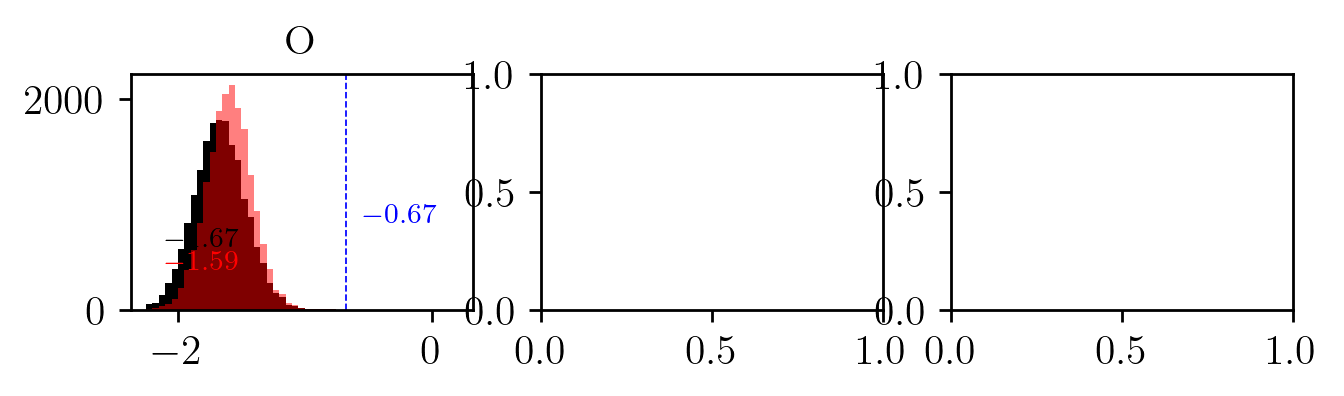

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(6, 6/3/1.6))

for ii, (ax, atom_type) in enumerate(zip(axs, ATOM_TYPES)):
    
    ax.set_title(atom_type)

    # Get the data
    pred = ensembles[atom_type].predict(data[atom_type]["test"]["x"])
    gt = data[atom_type]["test"]["y"]
    
    # Ensemble error itself
    ensemble_err = np.mean(np.abs(gt - pred.mean(axis=0)), axis=-1)
    log_ensemble_err = np.log10(ensemble_err)
    
    # Individual errors from each estimator
    individual_errs = np.mean(np.abs(gt - pred), axis=-1)
    log_individual_errs = np.log10(individual_errs)
    avg_log_estimator_err = np.mean(log_individual_errs, axis=0)
    
    # Average testing set error as a baseline
    average_spectrum_in_testing_set = np.mean(gt, axis=0)
    dummy_testing_set_error = np.log10(np.mean(np.abs(average_spectrum_in_testing_set - gt)))
    ax.axvline(dummy_testing_set_error, color="blue", linestyle="--", linewidth=0.5, zorder=0)
    
    print(atom_type)
    print(log_ensemble_err.shape, avg_log_estimator_err.shape)
    
    # Plot
    bins = [0.2 - ii * 0.05 for ii in range(50)][::-1]
    ax.hist(log_ensemble_err, bins=bins, color="black", label=r"$\varepsilon^{(i)}$" if ii==1 else None)
    ax.hist(avg_log_estimator_err, bins=bins, color="red", alpha=0.5, label=r"$\varepsilon_\mathrm{est}^{(i)}$" if ii==1 else None)
    ax.text(0.1, 0.3, r"$%.02f$" % np.median(log_ensemble_err), color="black", ha="left", va="center", transform=ax.transAxes, fontsize=8)
    ax.text(0.1, 0.2, r"$%.02f$" % np.median(avg_log_estimator_err), color="red", ha="left", va="center", transform=ax.transAxes, fontsize=8)
    t = ax.text(0.9, 0.4, r"$%.02f$" % dummy_testing_set_error, color="blue", ha="right", va="center", transform=ax.transAxes, fontsize=8)
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    
    # Fine tuning
    adj.set_grids(ax, grid=False)
    ax.set_yticklabels([])
    ax.set_xticks([-3, -2, -1, 0])
    adj.set_xlim(ax, -3, 0)
    
    if ii == 0:  # Carbon
        val = 7500
        ax.text(0.1, 0.8, val, ha="left", va="center", transform=ax.transAxes, color="gray") 
    elif ii == 1:  # Nitrogen
        val = 1000
        ax.text(0.1, 0.8, val, ha="left", va="center", transform=ax.transAxes, color="gray") 
    else:  # Oxygen
        val = 1500
        ax.text(0.1, 0.8, val, ha="left", va="center", transform=ax.transAxes, color="gray") 

    ax.axhline(val, color="gray", linestyle="--", linewidth=0.5, zorder=0)
    
        
axs[1].set_xlabel(r"$\log_{10} \varepsilon^{(i)}$")
axs[0].set_ylabel("Counts")
axs[1].legend(frameon=False, loc="center left", fontsize=10)

plt.subplots_adjust(wspace=0.1)

# plt.savefig("qm9_hists.svg", bbox_inches="tight", dpi=300)
# needs post-processing on InkScape
plt.show()

## Plot the correlation between error and std

/home/mcarbone/miniconda3/envs/py3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


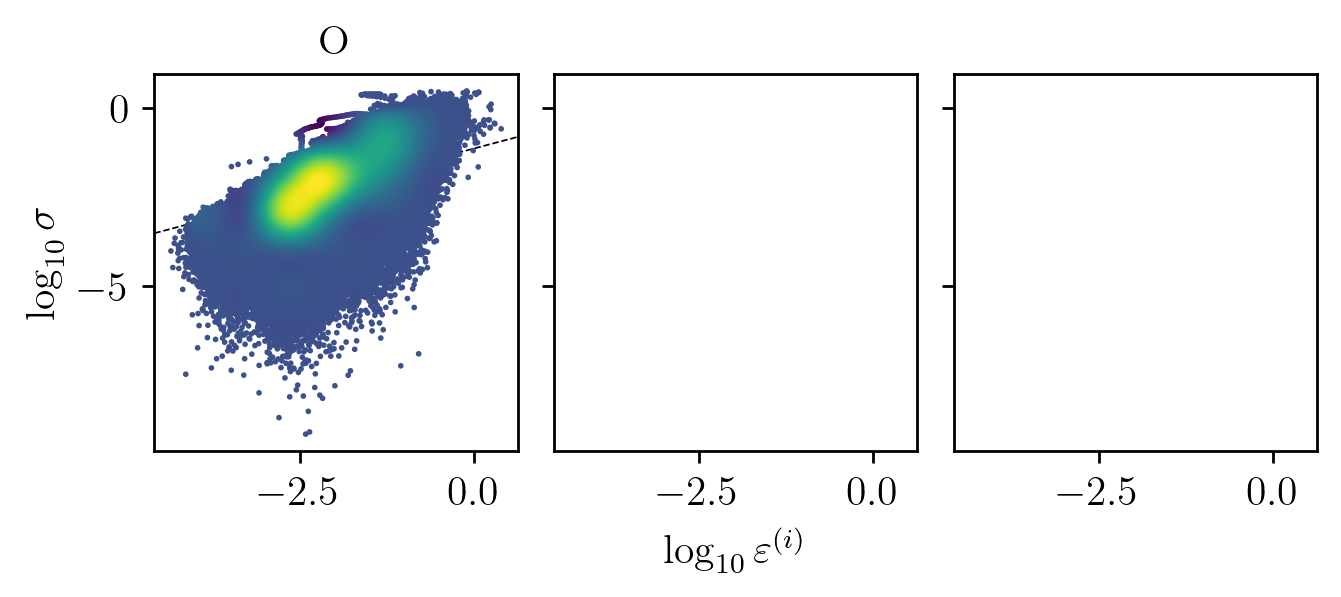

In [16]:
debug = None

fig, axs = plt.subplots(1, 3, figsize=(6, 2), sharex=True, sharey=True)

bins_map = {"C": 70, "N": 10, "O": 10}
    
for ii, atom_type in enumerate(ATOM_TYPES):
    
    # Not exactly efficient to do this every time but it's fast enough...
    pred = ensembles[atom_type].predict(data[atom_type]["test"]["x"])
    gt = data[atom_type]["test"]["y"]
    
    # Pointwise
    ensemble_pointwise_err = np.abs(gt - pred.mean(axis=0)).flatten()
    ensemble_pointwise_std = pred.std(axis=0).flatten()

    # Spectrum-wise
    ensemble_err = np.abs(gt - pred.mean(axis=0)).mean(axis=1)
    ensemble_std = pred.std(axis=0).mean(axis=-1)

    ax = axs[ii]
    ax.set_title(atom_type)
    # x = np.log10(ensemble_err[::debug])
    # y = np.log10(ensemble_std[::debug])
    # ax = density_scatter(x, y, ax=ax, sort=True, bins=bins_map[atom_type], s=0.4, alpha=1, rasterized=True)
    # idx = np.argsort(x)
    # p = np.polyfit(x[idx], y[idx], deg=1)
    # poly = np.poly1d(p)
    # ax.axline((-3, poly(-3)), (-2, poly(-2)), color="black", zorder=0, linestyle="--", linewidth=0.5)

    x = np.log10(ensemble_pointwise_std[::debug])
    y = np.log10(ensemble_pointwise_err[::debug])
    ax = density_scatter(x, y, ax=ax, sort=True, bins=bins_map[atom_type], s=0.4, alpha=1)
    idx = np.argsort(x)
    p = np.polyfit(x[idx], y[idx], deg=1)
    poly = np.poly1d(p)
    ax.axline((-3, poly(-3)), (-2, poly(-2)), color="black", zorder=0, linestyle="--", linewidth=0.5)

# for ax in axs.flatten():
#     ax.set_xlim(-3, 0)
#     ax.set_ylim(-3, 0)
#     ax.set_xticks([-3, -2, -1, 0])
#     ax.set_yticks([-3, -2, -1, 0])
#     adj.set_grids(ax, grid=False)
#     adj.set_xlim(ax, -3, 0)
#     adj.set_ylim(ax, -3, 0)

axs[1].set_xlabel(r"$\log_{10} \varepsilon^{(i)}$")
axs[0].set_ylabel(r"$\log_{10} \sigma$")

plt.subplots_adjust(wspace=0.1)

# plt.savefig("qm9_sigma_parity.svg", bbox_inches="tight", dpi=300)
plt.show()

## Everything together

In [ ]:
debug = None

fig, axs = plt.subplots(2, 3, figsize=(6, 3.3), gridspec_kw={"height_ratios": [1.3, 2]}, sharex=True)

for ii, atom_type in enumerate(ATOM_TYPES):
    
    
    #### UPPER PLOTS ####
    
    ax = axs[0, ii]
    
    ax.set_title(atom_type)

    # Get the data
    pred = ensembles[atom_type].predict(data[atom_type]["test"]["x"])
    gt = data[atom_type]["test"]["y"]
    
    # Ensemble error itself
    ensemble_err = np.mean(np.abs(gt - pred.mean(axis=0)), axis=-1)
    log_ensemble_err = np.log10(ensemble_err)
    
    # Individual errors from each estimator
    individual_errs = np.mean(np.abs(gt - pred), axis=-1)
    log_individual_errs = np.log10(individual_errs)
    avg_log_estimator_err = np.mean(log_individual_errs, axis=0)
    
    # Average testing set error as a baseline
    average_spectrum_in_testing_set = np.mean(gt, axis=0)
    dummy_testing_set_error = np.log10(np.mean(np.abs(average_spectrum_in_testing_set - gt)))
    ax.axvline(dummy_testing_set_error, color="blue", linestyle="--", linewidth=0.5, zorder=0)
    
    print(atom_type)
    print(log_ensemble_err.shape, avg_log_estimator_err.shape)
    
    # Plot
    bins = [0.2 - ii * 0.05 for ii in range(50)][::-1]
    ax.hist(log_ensemble_err, bins=bins, color="black", label=r"$\varepsilon^{(i)}$" if ii==1 else None)
    ax.hist(avg_log_estimator_err, bins=bins, color="red", alpha=0.5, label=r"$\varepsilon_\mathrm{est}^{(i)}$" if ii==1 else None)
    ax.text(0.1, 0.3, r"$%.02f$" % np.median(log_ensemble_err), color="black", ha="left", va="center", transform=ax.transAxes, fontsize=8)
    ax.text(0.1, 0.2, r"$%.02f$" % np.median(avg_log_estimator_err), color="red", ha="left", va="center", transform=ax.transAxes, fontsize=8)
    t = ax.text(0.9, 0.4, r"$%.02f$" % dummy_testing_set_error, color="blue", ha="right", va="center", transform=ax.transAxes, fontsize=8)
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    
    # Fine tuning
    adj.set_grids(ax, grid=False)
    ax.set_yticklabels([])
    ax.set_xticks([-3, -2, -1, 0])
    adj.set_xlim(ax, -3, 0)
    
    if ii == 0:  # Carbon
        val = 5000
        ax.text(0.1, 0.8, val, ha="left", va="center", transform=ax.transAxes, color="gray") 
    elif ii == 1:  # Nitrogen
        val = 1000
        ax.text(0.1, 0.8, val, ha="left", va="center", transform=ax.transAxes, color="gray") 
    else:  # Oxygen
        val = 1000
        ax.text(0.1, 0.8, val, ha="left", va="center", transform=ax.transAxes, color="gray") 

    ax.axhline(val, color="gray", linestyle="--", linewidth=0.5, zorder=0)
    
    #### LOWER PLOTS ####
    
    # Pointwise
    ensemble_pointwise_err = np.abs(gt - pred.mean(axis=0)).flatten()
    ensemble_pointwise_std = pred.std(axis=0).flatten()

    # Spectrum-wise
    ensemble_err = np.abs(gt - pred.mean(axis=0)).mean(axis=1)
    ensemble_std = pred.std(axis=0).mean(axis=-1)
    
    ax = axs[1, ii]
    x = np.log10(ensemble_err[::debug])
    y = np.log10(ensemble_std[::debug])
    ax = density_scatter(x, y, ax=ax, sort=True, bins=bins_map[atom_type], s=0.4, alpha=1, rasterized=True)
    idx = np.argsort(x)
    p = np.polyfit(x[idx], y[idx], deg=1)
    poly = np.poly1d(p)
    ax.axline((-3, poly(-3)), (-2, poly(-2)), color="black", zorder=0, linestyle="--", linewidth=0.5)
    r2 = np.corrcoef(x[idx], y[idx])[0, 1]**2
    ax.text(0.1, 0.1, r"$r^2 = %.02f$" % r2, ha="left", va="bottom", transform=ax.transAxes)
    
    
    ax.set_xlim(-3, 0)
    ax.set_ylim(-3, 0)
    ax.set_xticks([-3, -2, -1, 0])
    ax.set_yticks([-3, -2, -1, 0])
    adj.set_grids(ax, grid=False)
    adj.set_xlim(ax, -3, 0)
    adj.set_ylim(ax, -3, 0)
    
# axs[0, 1].set_xlabel(r"$\log_{10} \varepsilon^{(i)}$")
axs[1, 1].set_xlabel(r"$\log_{10} \varepsilon^{(i)}$")
axs[0, 0].set_ylabel("Counts")
axs[1, 0].set_ylabel(r"$\log_{10} \sigma$")
axs[0, 1].legend(frameon=False, loc="center left", fontsize=10)

axs[1, 1].set_yticklabels([])
axs[1, 2].set_yticklabels([])

letters = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
for letter, ax in zip(letters, axs.flatten()):
    ax.text(0.1, 0.5, letter, ha="left", va="center", transform=ax.transAxes)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig("qm9_hists.svg", bbox_inches="tight", dpi=300)
# needs post-processing on InkScape
# plt.show()

## Plot some examples

In [ ]:
atom_type = "C"
grid = data[atom_type]["train"]["grid"]
pred = ensembles[atom_type].predict(data[atom_type]["test"]["x"])
gt = data[atom_type]["test"]["y"]

In [ ]:
err = np.mean(np.abs(gt - pred.mean(axis=0)), axis=1)
sorted_idx = np.argsort(err)[::-1]

In [ ]:
len(sorted_idx)

In [ ]:
err[sorted_idx][:10]

In [ ]:
(pred[:, sorted_idx, :].std(axis=0) * 3)[:10].mean(axis=1)

In [ ]:
names = [data[atom_type]["test"]["names"][ii] for ii in sorted_idx[:10]]
names

In [ ]:
names = [data[atom_type]["test"]["origin_smiles"][ii] for ii in sorted_idx[:10]]
names

In [ ]:
from rdkit import Chem

In [ ]:
grid = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smile) for smile in names[:3]], useSVG=True)

In [ ]:
with open("qm9_C_fail.svg", "w") as f:
    f.write(grid.data)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 5))

n = 10
for ii in range(n):
    
    offset = ii * 6
    idx = sorted_idx[int(ii / n * len(sorted_idx)) + 11]
    
    ground_truth_spectra = gt[idx, :]
    predicted_spectra = pred[:, idx, :]

    mu = predicted_spectra.mean(axis=0) + offset
    
    sd = predicted_spectra.std(axis=0) * 3
    
    label = r"$\mu^{(i)}$" if ii == 0 else None
    ax.plot(grid, ground_truth_spectra + offset, "k-", label=label)

    # label = r"$\hat{\mu}^{(i)}$" if ii == 0 else None
    # ax.plot(grid, mu, color="purple", linewidth=1, label=label)
    
    for jj, prediction in enumerate(predicted_spectra):
        label = r"$\hat{\mu}^{(i, k)}$" if jj == 0 and ii == 0 else None 
        ax.plot(grid, prediction + offset, 'r-', linewidth=0.5, alpha=0.5, label=label)
    
    label = r"$3\sigma$" if ii == 0 else None
    ax.fill_between(grid, mu - sd, mu + sd, color="red", alpha=0.5, linewidth=0, label=label)
    
    err = np.log10(np.mean(np.abs(ground_truth_spectra - predicted_spectra))).item()
    ax.text(0.9, 0.09 + ii / 10.5, r"$%.02f$" % err, ha="right", va="center", transform=ax.transAxes)
    
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(0.5)
ax.spines["bottom"].set_linewidth(0.5)
adj.set_grids(ax, grid=False, top=False)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xlabel(r"$E$~(e.V.)")
ax.set_ylabel(r"$\mu(E)$~(a.u.)")
ax.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.1))

# err = np.log10(np.mean(np.abs(gt[ii] - pred[ii])))
# print(f"{err:.02f}")


# plt.show()
plt.savefig("qm9_C_random_preds.svg", bbox_inches="tight", dpi=300)